In [1]:
import os
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import Preprocessing as pp

In [2]:
TOTAL_TIME = 12231 #total time for experiment in seconds
SAMPLING_RATE = 1 #number of samples per seconds wished (so 0.5 for a sample every 2 seconds)
sample_size = math.ceil(TOTAL_TIME*SAMPLING_RATE) +1 # +1 for starting and end point
time_downsampled = np.arange(sample_size) 

OPEN_FOLDER = "../Data/Raw_Data/" # where are the raw matlab files?
SAVE_FOLDER = "../Data/Temp_Data/" # where do you want to save the .csv files

open_4b = OPEN_FOLDER + "Messdaten_Test_ID_4b/"
open_9 = OPEN_FOLDER + "Messdaten_Test_ID_9/"

pp.checkFolder(SAVE_FOLDER)

Folder already exists.


In [3]:
def prepData4B(data, endtime):
    df = pd.DataFrame()
    time, input_voltage = pp.fillData(data[0]['t_nsoll_stil'], data[0]['sw_nsoll_stil'])
    dummy, spinning_soll = pp.fillData(data[0]['t_nsoll_stil'], data[0]['n_4b_soll'])
    dummy, spinning_approx = pp.applyConstraint(data[0]['t_stil'], data[0]['n_stil'])
    dummy, el_power = pp.fillData(data[1]['t_1B_el_neu'], data[1]['P_el_rms'])
    dummy, el_power_approx = pp.fillData(data[1]['t_elstil'], data[1]['P_elstil'])
    th_power = pp.downsampleData(data[1]['t_1B_el_neu'], data[1]['P_th'][::2])[:endtime]
    dummy, th_power_approx = pp.fillData(data[1]['t_thstil'], data[1]['P_thstil'])
    
    time = time[:endtime]
    input_voltage = input_voltage[:endtime]
    spinning_soll = spinning_soll[:endtime]
    spinning_approx = spinning_approx[:endtime]
    el_power = el_power[:endtime]
    el_power_approx = el_power_approx[:endtime]
    th_power = th_power[:endtime]
    th_power_approx = th_power_approx[:endtime]
    
    df['time'] = time
    df['input_voltage'] = input_voltage
    df['spinning_soll'] = spinning_soll
    df['spinning_approx'] = spinning_approx
    df['el_power'] = el_power
    df['el_power_approx'] = el_power_approx
    df['th_power'] = th_power[:,1]
    df['th_power_approx'] = th_power_approx
    
    return df

In [4]:
def data4B_raw(df):
    df_spin, df_power = df    
    df_raw = pd.DataFrame()
    
    df_raw['el_power'] = df_power['P_el_rms']
    df_raw['th_power'] = df_power['P_th'][::2]
    df_raw['time'] = df_power['t_1B_el_neu']
    df_raw['spinning_soll'] = np.empty(len(df_raw['time']))
    df_raw['input_voltage'] =np.empty(len(df_raw['time']))
    
    for t in range (len(df_spin['t_nsoll_stil']) -1):
        t_start = df_spin['t_nsoll_stil'][t]
        t_end = df_spin['t_nsoll_stil'][t+1]
        ix_start = np.argmax(df_raw.time >= t_start)
        ix_end = np.argmax(df_raw.time > t_end)
        
        df_raw['spinning_soll'][ix_start:ix_end] = df_spin['n_4b_soll'][t]
        df_raw['input_voltage'][ix_start:ix_end] = df_spin['sw_nsoll_stil'][t]
        
    return df_raw

In [5]:
def prepData9(data, endtime):
    df = pd.DataFrame()
    time = pp.downsampleData(data[0]['t_n'], data[0]['t_n'],sample_size=endtime)[:, 1]
    input_voltage = pp.downsampleData(data[0]['t_n'], data[0]['u_ary'], sample_size=endtime)[:, 1]
    spinning_soll = pp.downsampleData(data[0]['t_n'], data[0]['n_soll'], sample_size=endtime)[:, 1]
    time_splits = [time[i] for i in range(len(time)-1) if abs(input_voltage[i] - input_voltage[i+1]) > 0.01]
    value_splits = [spinning_soll[i] for i in range(len(spinning_soll)-1) if abs(input_voltage[i] - input_voltage[i+1]) > 0.01]
    time_splits.insert(0, 0)
    value_splits.insert(0, spinning_soll[0])
    time_splits.append(time[-1])
    value_splits.append(spinning_soll[-1])
    dummy, spinning_approx = pp.applyConstraint(time_splits, value_splits)
    el_power = pp.downsampleData(data[1]['t_pel'][::2], data[1]['P_el_rms'][::2], sample_size=endtime)[:,1]
    el_power_approx = pp.downsampleData(data[1]['t_pel'][::2], data[1]['p_pel'][::2], sample_size=endtime)[:,1]
    th_power = pp.downsampleData(data[1]['t_n_th'], data[1]['P_th_mean'], sample_size=endtime)[:,1]
    dummy, th_power_approx = pp.fillData(data[1]['t_pth'][::2], data[1]['p_pth'][::2])

    time = time[:endtime]
    input_voltage = input_voltage[:endtime]
    spinning_soll = spinning_soll[:endtime]
    spinning_approx = spinning_approx[:endtime]
    el_power = el_power[:endtime]
    el_power_approx = el_power_approx[:endtime]
    th_power = th_power[:endtime]
    th_power_approx = th_power_approx[:endtime]
    
    df['time'] = time
    df['input_voltage'] = input_voltage
    df['spinning_soll'] = spinning_soll
    df['spinning_approx'] = spinning_approx
    df['el_power'] = el_power
    df['el_power_approx'] = el_power_approx
    df['th_power'] = th_power
    df['th_power_approx'] = th_power_approx
    
    return df

In [6]:
def plotCrossPlots(df):
    fig, axs = plt.subplots(len(df.columns), len(df.columns), figsize = (30,30))
    axs = axs.ravel()
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            number = i*len(df.columns) + j
            axs[number].plot(df[df.columns[i]], df[df.columns[j]])
            axs[number].set_title(df.columns[i] + " (x) + " + df.columns[j])
    plt.show()

# Prepare and Plot Data according to Test_ID_4b

In [7]:
raw_data_4b = pp.openMatfiles(open_4b)

Drehzahldaten_Test_ID_4b.mat
Leistungdaten_Test_ID_4b.mat


In [8]:
data_spinning_4b = raw_data_4b['Drehzahldaten_Test_ID_4b']
data_power_4b = raw_data_4b['Leistungdaten_Test_ID_4b']
data_4b = [data_spinning_4b, data_power_4b]

In [9]:
data_4b_raw = data4B_raw(data_4b)
data_4b_raw.to_csv(SAVE_FOLDER + 'experiment_4b_raw.csv',
         index = False, sep =  "|", encoding = "utf-8")

In [10]:
df_4b = prepData4B(data_4b, 11290)
df_4b.to_csv(SAVE_FOLDER + 'experiment_4b.csv',
         index = False, sep =  "|", encoding = "utf-8")

In [11]:
df_4b_short = df_4b[750:]

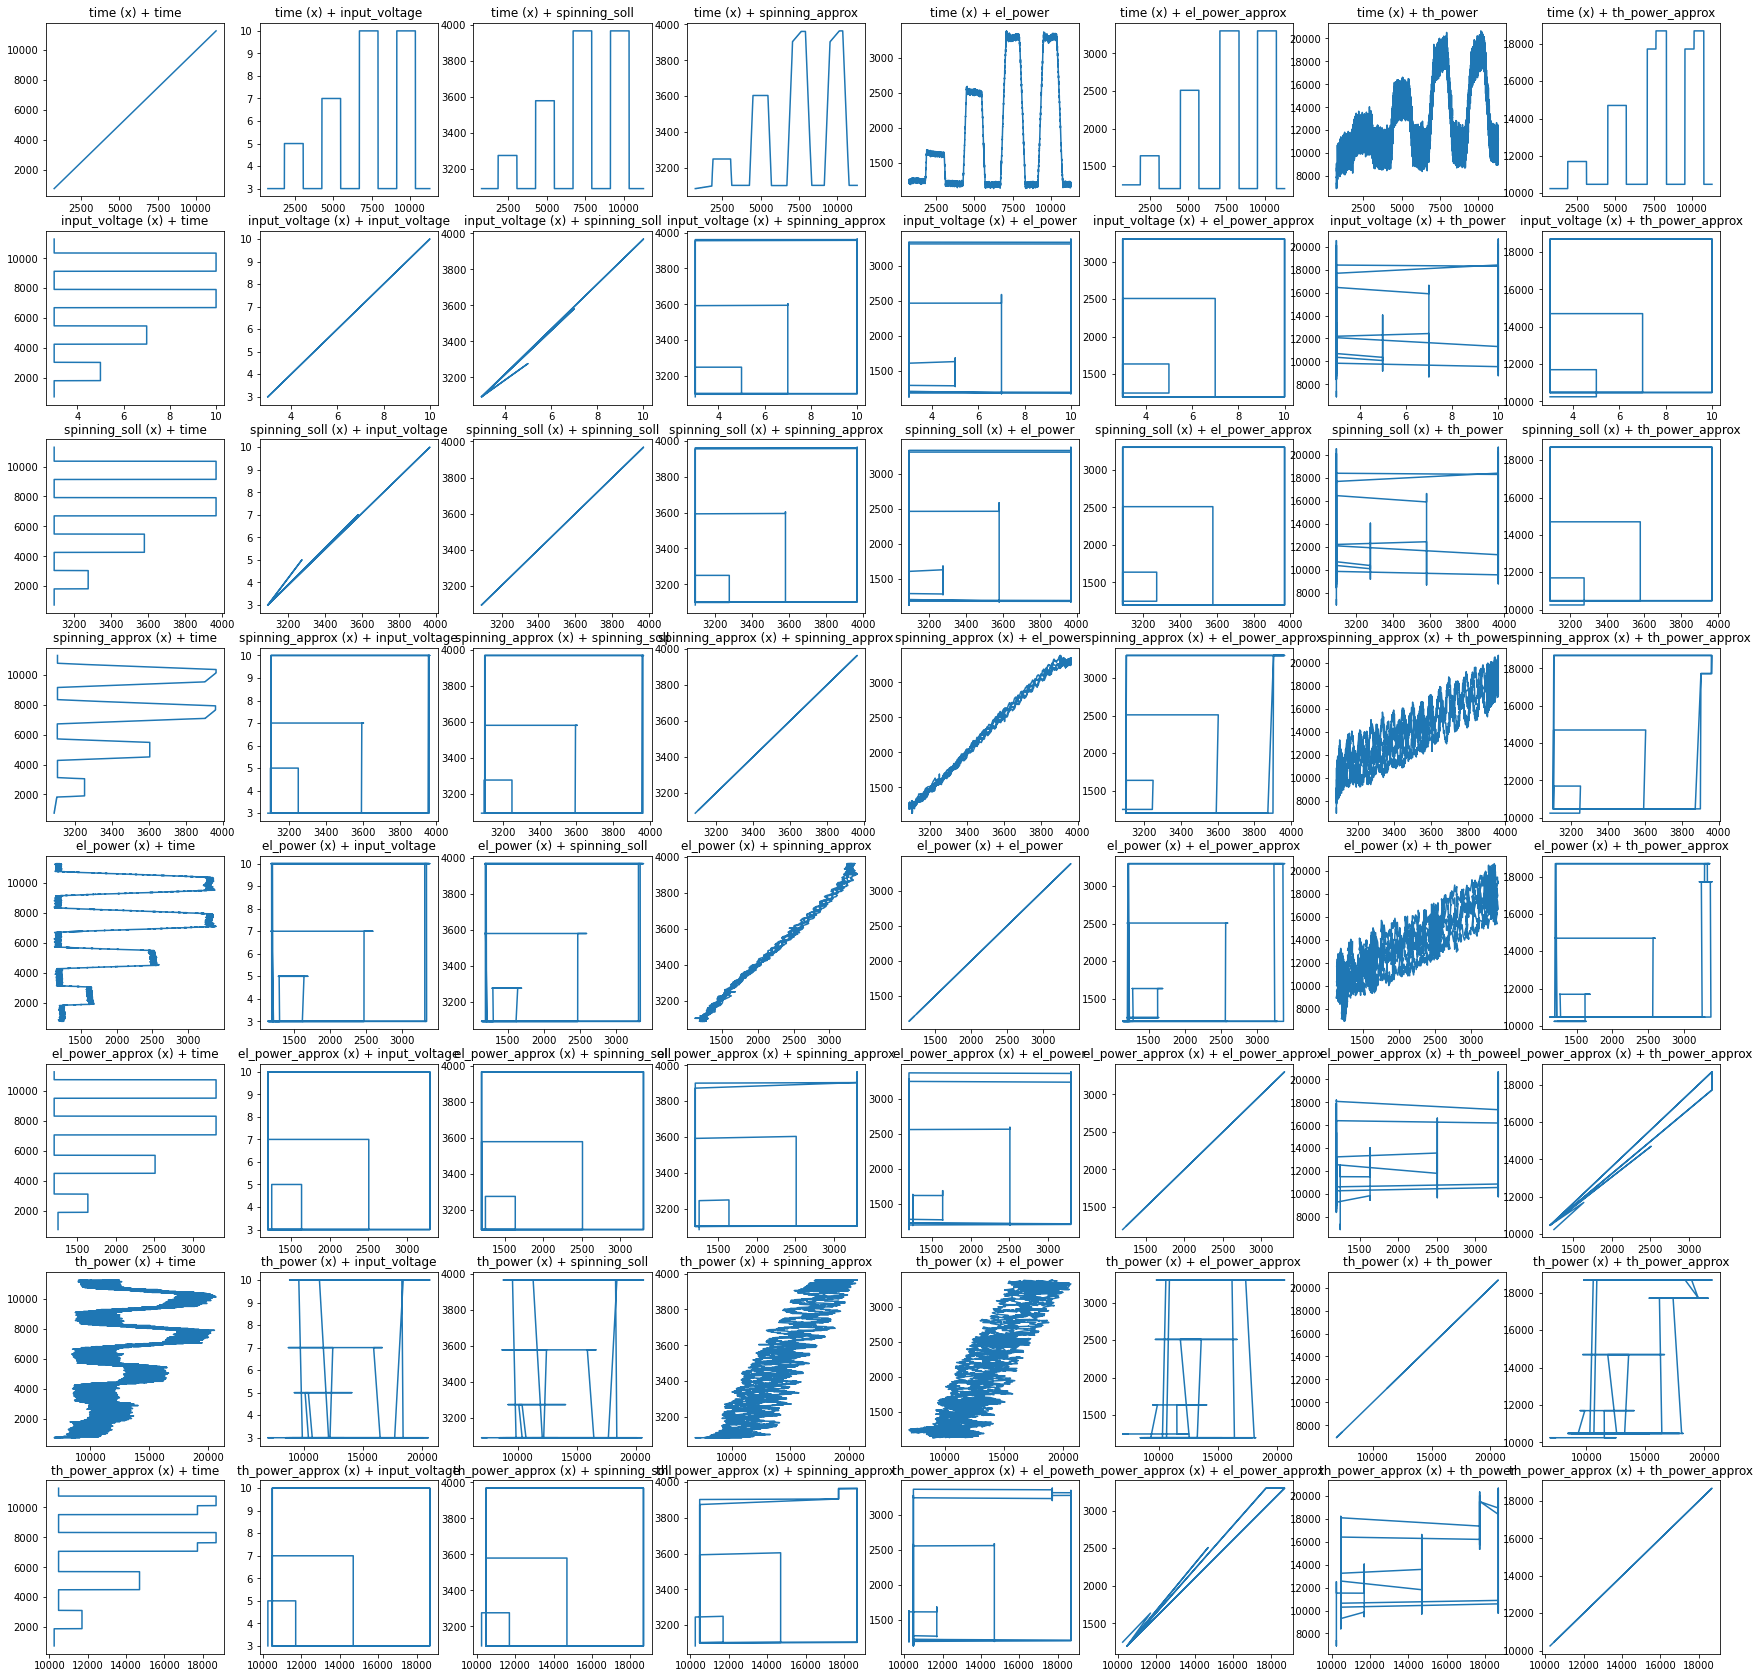

In [12]:
plotCrossPlots(df_4b_short)

In [13]:
df_4b_short.to_csv(SAVE_FOLDER + 'experiment_4b_short.csv',
         index = False, sep =  "|", encoding = "utf-8")

# Prepare and Plot Data according to Test_ID_9

In [14]:
raw_data_9 = pp.openMatfiles(open_9)

Drehzahldaten_Test_ID_9.mat
Leistungdaten_Test_ID_9.mat


In [16]:
data_spinning_9 = raw_data_9['Drehzahldaten_Test_ID_9']
data_power_9 = raw_data_9['Leistungdaten_Test_ID_9']
data_9 = [data_spinning_9, data_power_9]

In [15]:
def data9_raw(df):
    df_spin, df_power = df    
    df_raw = pd.DataFrame()
    
    df_raw['el_power'] = df_power['P_el_rms']
    df_raw['th_power'] = np.repeat(df_power['P_th_mean'], 50)[:len(df_raw['el_power'])]
    df_raw['time'] = df_spin['t_n']
    df_raw['spinning_soll'] = np.empty(len(df_raw['time']))
    df_raw['input_voltage'] =np.empty(len(df_raw['time']))
    
    for t in range (len(df_spin['t_n']) -1):
        t_start = df_spin['t_n'][t]
        t_end = df_spin['t_n'][t+1]
        ix_start = np.argmax(df_raw.time >= t_start)
        ix_end = np.argmax(df_raw.time > t_end)
        
        df_raw['spinning_soll'][ix_start:ix_end] = df_spin['n_soll'][t]
        df_raw['input_voltage'][ix_start:ix_end] = df_spin['u_ary'][t]
        
    return df_raw

n_istabh 651843
n_nul 651843
n_reg 651843
n_soll 651843
t_n 651843
u_ary 651843
651843


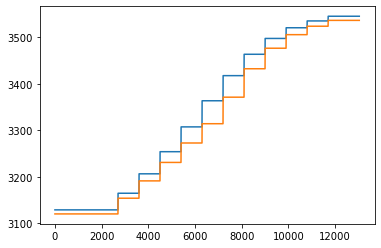

In [27]:
for h in list(data_spinning_9):
    print(h, len(data_spinning_9[h]))
print(len(data_spinning_9['t_n']))

plt.plot(data_spinning_9['t_n'], data_spinning_9['n_soll'])

plt.plot(data_spinning_9['t_n'], data_spinning_9['n_istabh'])

In [ ]:
data9_raw(data_9)

In [ ]:
data_9_raw = data9_raw(data_9)
data_9_raw.to_csv(SAVE_FOLDER + 'experiment_9_raw.csv',
         index = False, sep =  "|", encoding = "utf-8")

In [ ]:
df_9 = prepData9(data_9, 11600)
df_9.to_csv(SAVE_FOLDER + 'experiment_9.csv',
         index = False, sep =  "|", encoding = "utf-8")

In [ ]:
df_9_short = df_9[450:-400]

In [ ]:
plt.plot(df_9_short['time'], df_9_short['el_power'])
plt.plot(df_9_short['time'], df_9_short['th_power'])

In [ ]:
plotCrossPlots(df_9_short)

In [ ]:
df_9_short.to_csv(SAVE_FOLDER + 'experiment_9_short.csv',
         index = False, sep =  "|", encoding = "utf-8")